## Creating plots of TS density, grouped plots for sinking

This notebook will finalize diagrams for the thesis to insure that all use the same grouping of elements. This will slice the dataframe by one year and add the diagrams.

In [1]:
# Do not modify import block, all necessary imports are included
# Our regular libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
%matplotlib inline

# for plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# this is for density plotting
from matplotlib import colorbar, colors
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# for the polygon intersections
import shapely.geometry as sg
import descartes
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import cartopy.feature as cfeature
#from xgcm import Grid

# for plotting
import time
import warnings
warnings.filterwarnings('ignore')

# for gsw
import sys
sys.path.append('/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/')
import gsw

### Slice the points by one year, load the release points, load the dataframe for KMeans

In [2]:
# load the libraries
ds = xr.open_dataset('/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_flt.nc')
ds1 = xr.open_dataset('/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0001.nc')
dg = xr.open_dataset('/scratch/project_2000789/muramarg/copied_files/waom10extend_grd.nc')

### Or load from file

In [3]:
#wmt = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/wmt_final.txt",sep=",")
#wmt = wmt.reshape((35040,6586))
wmt = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/wmt_dsw.txt",sep=",")
wmt = wmt.reshape((35040,-1))

In [4]:
wmt.shape

(35040, 4458)

In [5]:
# write these to files? does this save time
xgrid = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/xgrid_dsw.txt",sep=",")
ygrid = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/ygrid_dsw.txt",sep=",")

xgrid = xgrid.reshape((35040,-1))
ygrid = ygrid.reshape((35040,-1))

In [6]:
temp = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/temp_dsw.txt",sep=",")
salt = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/salt_dsw.txt",sep=",")
depth = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/depth_dsw.txt",sep=",")
temp = temp.reshape((35040,-1))
depth = depth.reshape((35040,-1))
salt = salt.reshape((35040,-1))

In [7]:
# dens = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/dens.txt",sep=",")
# dens = dens.reshape((35040,7102))

In [8]:
pol_locs = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/pollocs_dsw.txt",sep=",")
pol_locs = pol_locs.astype(int)
pol_locs.shape

new_locs = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/newlocs2.txt",sep=",")
new_locs = new_locs.astype(int)

matching_indices = np.where(np.isin(pol_locs, new_locs))[0]

In [9]:
# xgrid = xgrid[:,matching_indices]
# ygrid = ygrid[:,matching_indices]
# temp = temp[:,matching_indices]
# depth = depth[:,matching_indices]
# salt = salt[:,matching_indices]

### Other setup conversions, load WM definitions

In [10]:
# load with 4 groups
group1 = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/GroupFiles/group1_dsw.txt",sep=",")
group2 = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/GroupFiles/group2_dsw.txt",sep=",")
group4 = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/GroupFiles/group3_dsw.txt",sep=",")
group3 = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/GroupFiles/group4_dsw.txt",sep=",")


# do intersect1d with matching_indices
group1 = group1.tolist()
group1 = [int(x) for x in group1]
group2 = group2.tolist()
group2 = [int(x) for x in group2]
group3 = group3.tolist()
group3 = [int(x) for x in group3]
group4 = group4.tolist()
group4 = [int(x) for x in group4]


group1 = np.intersect1d(group1,matching_indices)
group2 = np.intersect1d(group2,matching_indices)
group3 = np.intersect1d(group3,matching_indices)
group4 = np.intersect1d(group4,matching_indices)

In [11]:
groups = np.array([group1,group2,group3,group4],dtype=object)

In [12]:
# convert the waom values to gsw values
# convert depth to sea pressure
long = 73.5089
lat = -66.8245
p = gsw.p_from_z(z=depth,lat=-66.8245)


# convert the absolute salinity from practical salinity
SA = gsw.SA_from_SP(salt,p,long,lat)    # absolute salinity from practical salinity

# convert potential T to conservative T
CT = gsw.CT_from_pt(SA,temp)   # conservative T from potential T

# find the potential density from SA, CT, p
rho_pot = gsw.rho(SA,CT,p) - 1000

p0 = np.zeros(depth.shape)
SA0 = gsw.SA_from_SP(salt,p0,long,lat)    # absolute salinity from practical salinity

# convert potential T to conservative T
CT0 = gsw.CT_from_pt(SA0,temp)   # conservative T from potential T
rho_pot0 = gsw.rho(SA0,CT0,p0) - 1000

## Create the meshes

In [13]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [14]:
lat_values = dg.lat_rho.values
long_values = dg.lon_rho.values

# residence time
xbins = np.r_[0:630:1]
ybins = np.r_[0:560:1]

# index of bins the particles ending in
x_new = np.digitize(xgrid,xbins)
y_new = np.digitize(ygrid,ybins)

In [15]:
# residence time
import time
# create an empty array for the bin time
m2 = []
for i in range(len(xbins)):
    newl = []
    for j in range(len(ybins)):
        newl.append([])
    m2.append(newl)
    
# each bin has an average or total time that any one particle spends in it
# for each column
start_time = time.time()
for i in range(x_new.shape[1]):
#for i in range(5):
    if i % 1000 == 0:
        print(i,'of',x_new.shape[1],'in',(time.time()-start_time)/60)
    # get the x and y column values
    thisx = x_new[:,i]
    thisy = y_new[:,i]

    # make a stack of the x and y columns
    pts = np.vstack((thisx,thisy))
    pts = pts.T

    # normalize to the total number of particles
    counts = list(zip(*np.unique(pts, return_counts = True, axis = 0)))
    counts.pop()
    
    # add each count to a list in the mesh
    for ii in counts[:-1]:
        iind = ii[0][0]
        jind = ii[0][1]
        
        # create the mesh without the scaling by time
        myval = (ii[1]*900)/86400 # current sum of the column totals

        # see if the current number of the mesh is zero, if it is, add to list
        #print(m2[iind][jind])
        
        m2[int(iind)][int(jind)].append(myval)

0 of 4458 in 2.9842058817545575e-06
1000 of 4458 in 0.4014989217122396
2000 of 4458 in 0.792611304918925
3000 of 4458 in 1.1860268712043762
4000 of 4458 in 1.5984213987986247


In [16]:
# create the density map
x_sing = np.array([])
y_sing = np.array([])
start_time = time.time()
for col in range(x_new.shape[1]):
    if col % 500 == 0:
        print(col,'of',x_new.shape[1],'in',(time.time()-start_time)/60)
    # create a set of datapoints
    thisx = (x_new[:,col])
    thisy = (y_new[:,col])
    
    # create the array of the colum
    arr = np.vstack((thisx,thisy))
    arr = arr.T
    
    # create a set from the array so each coordinate visits each grid square once
    set_coords = list(set(map(tuple,arr)))
    for myset in set_coords:
        x_sing = np.append(x_sing,myset[0])
        y_sing = np.append(y_sing,myset[1])
        
pts = np.vstack((x_sing,y_sing))
pts = pts.T

# normalize to the total number of particles
counts = list(zip(*np.unique(pts, return_counts = True, axis = 0)))
num_positions = len(counts)
#print(counts)
print(num_positions)

# pop the nan values
counts.pop()

# we are dividing by the number of particles, not number of positions


0 of 4458 in 1.7563501993815103e-06
500 of 4458 in 0.2629116932551066
1000 of 4458 in 0.7999810894330343
1500 of 4458 in 1.8059634844462076
2000 of 4458 in 3.1918541193008423
2500 of 4458 in 4.967403948307037
3000 of 4458 in 7.6763640681902565
3500 of 4458 in 12.987513554096221
4000 of 4458 in 19.020915615558625
6006


(array([567., 331.]), 1)

In [17]:
num_particles = len(xgrid[0])
print(num_particles)

4458


In [18]:
mesh = np.zeros((len(xbins),len(ybins)))

for ii in counts[:-1]:
    iind = ii[0][0]
    jind = ii[0][1]
    # create the mesh without the scaling by time
    myval = ii[1]/num_particles
    
    # scale by time for one day
    myval = (myval/900)*86400
    
    mesh[int(iind)][int(jind)] = myval

[Xbins, Ybins] = np.meshgrid(ybins,xbins)

# # transform the Ybins and Xbins into lat/long points
lat = np.array([])
long = np.array([])

# # interpolate in latitude
x_shape = np.arange(dg.lat_rho.shape[0])
y_shape = np.arange(dg.lat_rho.shape[1])
# for each row
for i,j in zip(Xbins,Ybins):
    # for each column create the long and lat values
    row_long = np.array([])
    row_lat = np.array([])
    
    for a,b in zip(i,j):
        interp_x = a
        interp_y = b
        # interpolate in longitude
        thislong = long_values[interp_x,interp_y]
        # interpolate in latitude
        thislat = lat_values[interp_x,interp_y]
        
        row_long = np.append(row_long,thislong)
        row_lat = np.append(row_lat,thislat)
    
    if len(lat) == 0:
        lat = np.append(lat,row_lat)
        long = np.append(long,row_long)
    else:
        lat = np.vstack((lat,row_lat))
        long = np.vstack((long,row_long))

In [19]:
# AVERAGE MESH
avgmesh = np.zeros((len(xbins),len(ybins)))
slimit = 5

# create the mesh based on averages of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>slimit:
            avg = sum(m2[ii][jj])/len(m2[ii][jj])
            if avg<200:
                avgmesh[ii][jj] = avg

# STDEV MESH - MAKE THIS ONLY FOR BINS WITH >5 FLOATS, ELSE NPNAN
# set a value to see if we want to limit the bin size for zdev
mesh_std = np.zeros((len(xbins),len(ybins)))
# create the mesh based on maximum values of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>slimit:
            std = np.std(m2[ii][jj])
            mesh_std[ii][jj] = std

### Create the lateral density gradients

In [20]:
ds1  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0001.nc")
ds2  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0002.nc")
ds3  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0003.nc")
ds4  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0004.nc")
ds5  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0005.nc")
ds6  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0006.nc")
ds7  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0007.nc")
ds8  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0008.nc")
ds9  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0009.nc")
ds10 = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0010.nc")
ds11 = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0011.nc")
ds12 = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0012.nc")

In [21]:
idx = 0
dg = xr.open_dataset("/scratch/project_2000789/muramarg/copied_files/waom10extend_grd.nc")
lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]

dens1 = np.zeros((4,31,560,630))
for ds in ds1,ds2,ds3,ds4,ds5,ds6,ds7,ds8,ds9,ds10,ds11,ds12:
    print(idx)
    
    temp = ds.variables["temp"]
    salt = ds.variables["salt"]

    ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    #print(Zo_rho.shape)
    #print(ds.zeta.shape,ds.h.shape,ds.zice.shape)
    z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
    
    #print(z_rho.transpose("ocean_time", "s_rho","eta_rho","xi_rho").shape)
    ds.coords['z_rho'] = z_rho.transpose("ocean_time", "s_rho","eta_rho","xi_rho")

    # read grid file for lon/lat coordinates
    ds.coords['lat_rho']=lat_rho#.transpose() # put lat_rho into ds dataset
    ds.coords['lon_rho']=lon_rho#.transpose() # put lon_rho into ds dataset
    
    p = p = gsw.p_from_z(z=z_rho.transpose("ocean_time", "s_rho","eta_rho","xi_rho"),lat=-66.8245)

    
    #dens1 = dens1 + gsw.rho(salt,temp,1000)-1000
    dens1 = dens1 + gsw.rho(salt,temp,p)-1000
    idx += 1

0
1
2
3
4
5
6
7
8
9
10
11


In [22]:
# Handle interpolation from u and v grid to rho points:
# loop through the datasets and do the averaging
i = 0

for ds in ds1,ds2,ds3,ds4,ds5,ds6,ds7,ds8,ds9,ds10,ds11,ds12:
    print(i)

    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta + ds.zice
    Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
    z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta + ds.zice

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    
    i += 1

0
1
2
3
4
5
6
7
8
9
10
11


In [23]:
# I don't think this is what we want - we want based on z, not bathymetry
# depth will be ds.z_rho * ds_s_w for thicknesses

bathymetry = np.array(ds1.z_rho[0][0].values)            # bathymetry

s_rho = ds1.s_rho.values
s_rho_fraction = np.array((1+s_rho))

depths = np.full((31,560,630),np.nan)

# for each column, get corresponding depth_sample  - sample depth

# fill depths[0] with ds1.s_rho * sample_depth
for y in range(depths.shape[1]):
    for x in range(depths.shape[2]):
        sample = bathymetry[y][x]
        #print(sample,s_rho_fraction.shape)
        array_depths = sample*s_rho_fraction           # array of sample depths at each layer
        depths[:,y,x] = array_depths

dz = np.diff(depths,axis=0)

# create the mask
mask = (depths >= -400) & (depths <= -100)

# do delta z and mask out depths not in range
dz = np.diff(depths,axis=0)
dz = np.pad(dz, ((1, 0), (0, 0), (0, 0)), mode='constant', constant_values=0)

# depths[~mask] = np.nan
# dz[~mask] = np.nan
dz = dz.reshape((1,dz.shape[0],dz.shape[1],dz.shape[2]))

mask = np.array(mask.astype(int))
print(mask.shape)
mask = mask.reshape(1,31,560,630)

(31, 560, 630)


In [27]:
dz = np.abs(dz)

In [28]:
# idx = 0
# long2 = 73.5089
# lat2 = -66.8245
# dx = 10000     # m
# dy = 10000     # m

# mask = (ds1.z_rho[0][0] >= -400) & (ds1.z_rho[0][0] <= -100)
# z_rho_masked = ds1.z_rho[0][0].where(mask)
# z_rho_masked = xr.where(~np.isnan(z_rho_masked), 1, z_rho_masked)
# mask = np.array(mask.astype(int))
# mask = mask.reshape(1,1,560,630)

# # 
# # plt.pcolormesh(z_rho_masked)

# #for ds in ,ds4,ds5,ds6,ds7,ds8,ds9,ds10,ds11,ds12:
# int_grad = np.zeros((4,560,630))
# for ds in ds1,ds2,ds3,ds4,ds5,ds6,ds7,ds8,ds9,ds10,ds11,ds12:
#     print("set",idx)
#     dens2 = np.zeros((4,31,560,630))
    
#     #### get salt and temp
#     temp = ds.variables["temp"]
#     salt = ds.variables["salt"]
#     p = ds.coords['z_rho'][0][0]
#     SA = gsw.SA_from_SP(np.array(salt),np.array(p),long2,lat2)
#     CT = gsw.CT_from_pt(SA,np.array(temp))
#     dens2 = dens2 + gsw.rho(SA,CT,0)-1000           # density matrix, shape t,z,y,x
    
#     #d_rho_dx = spatial_derivative(dens2, 3)
#     #d_rho_dy = spatial_derivative(dens2, 2)
#     dens2_x = np.pad(dens2, ((0, 0), (0, 0), (0, 0), (1, 1)), mode='edge')
#     d_rho_dx = np.diff(dens2_x, axis=3) / dx
#     dens2_y = np.pad(dens2, ((0, 0), (0, 0), (1, 1), (0, 0)), mode='edge')
#     d_rho_dy = np.diff(dens2_y, axis=2) / dy                  # kg/m^4
    
#     magnitude_gradient = np.sqrt(d_rho_dx[:,:,:,:-1]**2 + d_rho_dy[:,:,:-1,:]**2)
#     magnitude_gradient *= dz
#     #magnitude_gradient /= 300
#     magnitude_gradient = np.array(magnitude_gradient)
    
#     magnitude_gradient = magnitude_gradient
    
#     integrated_gradient = np.sum(magnitude_gradient, axis=1)    # move to shape time, x, y
    
#     int_grad += integrated_gradient
    
#     idx += 1
    
# # levels = np.arange(-0.2,0,0.02)
# levels = np.arange(0,0.2,0.02)
# print(levels)

# tmp = (np.sum(int_grad,axis=0)/4)

# cmap = plt.get_cmap('rainbow',20).copy()
# plt.contour(tmp, levels=levels,linestyles="solid",cmap=cmap)
# plt.colorbar(label="kg/m^4")
# plt.xlim(400,600)
# plt.ylim(300,500)
# # plt.colorbar()

ERROR! Session/line number was not unique in database. History logging moved to new session 773


set 0
set 1
set 2
set 3
set 4
set 5
set 6
set 7
set 8
set 9
set 10
set 11
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18]


(300.0, 500.0)

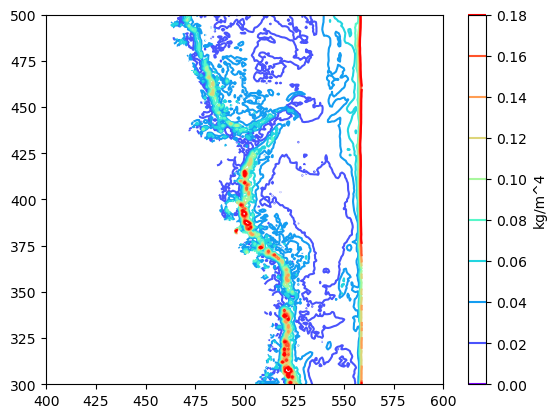

In [29]:
idx = 0
long2 = 73.5089
lat2 = -66.8245
dx = 10000     # m
dy = 10000     # m

mask = (ds1.z_rho[0][0] >= -400) & (ds1.z_rho[0][0] <= -100)
z_rho_masked = ds1.z_rho[0][0].where(mask)
z_rho_masked = xr.where(~np.isnan(z_rho_masked), 1, z_rho_masked)
mask = np.array(mask.astype(int))
mask = mask.reshape(1,1,630,560)

# 
# plt.pcolormesh(z_rho_masked)

#for ds in ,ds4,ds5,ds6,ds7,ds8,ds9,ds10,ds11,ds12:
int_grad = np.zeros((4,630,560))
for ds in ds1,ds2,ds3,ds4,ds5,ds6,ds7,ds8,ds9,ds10,ds11,ds12:
    print("set",idx)
    dens2 = np.zeros((4,31,630,560))
    
    #### get salt and temp
    temp = np.swapaxes(ds.variables["temp"],2,3)
    salt = np.swapaxes(ds.variables["salt"],2,3)
    p = ds.coords['z_rho'][0][0].T
    SA = gsw.SA_from_SP(np.array(salt),np.array(p),long2,lat2)
    CT = gsw.CT_from_pt(SA,np.array(temp))
    dens2 = dens2 + gsw.rho(SA,CT,0)-1000           # density matrix, shape t,z,y,x
    
    #d_rho_dx = spatial_derivative(dens2, 3)
    #d_rho_dy = spatial_derivative(dens2, 2)
    dens2_x = np.pad(dens2, ((0, 0), (0, 0), (1, 1), (0, 0)), mode='edge')
    d_rho_dx = np.diff(dens2_x, axis=2) / dx
    dens2_y = np.pad(dens2, ((0, 0), (0, 0), (0, 0), (1, 1)), mode='edge')
    d_rho_dy = np.diff(dens2_y, axis=3) / dy                  # kg/m^4
    
    #print(d_rho_dx.shape,d_rho_dy.shape)
    
    magnitude_gradient = np.sqrt(d_rho_dx[:,:,:-1,:]**2 + d_rho_dy[:,:,:,:-1]**2)   # kg/m^3/m
    magnitude_gradient *= np.swapaxes(dz,2,3)
    #magnitude_gradient /= 300
    magnitude_gradient = np.array(magnitude_gradient)
    
    magnitude_gradient = magnitude_gradient
    
    integrated_gradient = np.sum(magnitude_gradient, axis=1)    # move to shape time, x, y
    
    int_grad += integrated_gradient
    
    idx += 1
    
levels = np.arange(0,0.2,0.02)
print(levels)

tmp = (np.sum(int_grad,axis=0)/4)

cmap = plt.get_cmap('rainbow',20).copy()
plt.contour(tmp, levels=levels,linestyles="solid",cmap=cmap)
plt.colorbar(label="kg/m^4")
plt.xlim(400,600)
plt.ylim(300,500)

### Now plot!

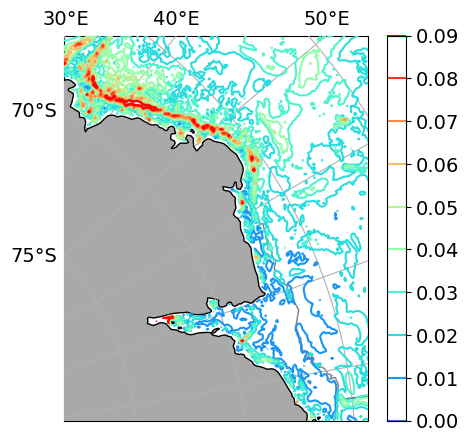

In [42]:
# test plotting
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(5,5))
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
plt.rcParams.update({'font.size': 14})

ax = fig.add_subplot(111, projection=proj)
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1290000,2900000])
plt.ylim([210000,2250000])
cmap = mpl.cm.get_cmap("rainbow",16).copy()
cmap = truncate_colormap(cmap, 0.15)
cmap.set_under(color='white')

# log scaling
ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='solid', linewidth=1,alpha=0.5)
plt.contour(dg.lon_rho[1:,300:], dg.lat_rho[1:,300:],ds1.zice[1:,300:],levels=[-0.1],
            zorder=2,linestyles='solid', transform=ccrs.PlateCarree(), cmap=plt.cm.binary,alpha=0.7)

levels = np.arange(0,0.1,0.01)
plt.contour(long[400:,300:],lat[400:,300:],tmp[400:,300:], levels=levels,transform=ccrs.PlateCarree(),linestyles="solid",cmap=cmap,zorder=10)
plt.colorbar()

# latlong ticks
gl = ax.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)

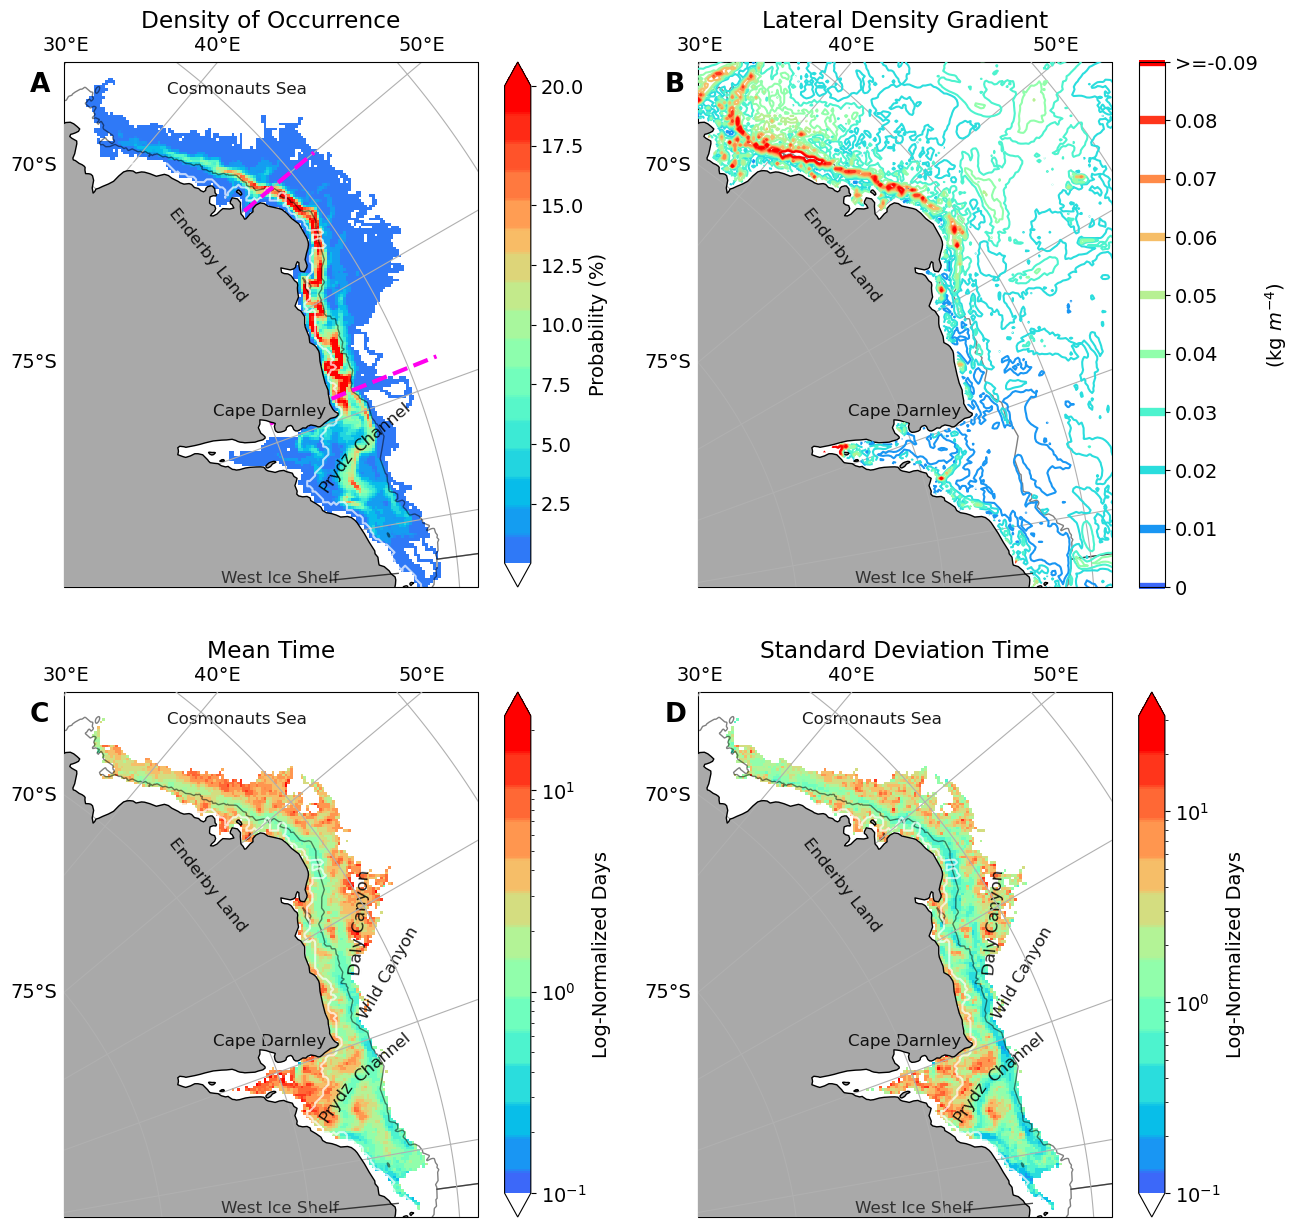

In [38]:
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(15,15))
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
plt.rcParams.update({'font.size': 14})

############################################################
# density map
# setup
# ax = plt.subplot2grid((4, 2), (0, 0), rowspan=4,projection=proj)
ax = fig.add_subplot(221, projection=proj)
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1290000,2900000])
plt.ylim([210000,2250000])
# cmap = plt.get_cmap('Blues',20).copy()
cmap = plt.get_cmap('rainbow',20).copy()

cmap = truncate_colormap(cmap, 0.15)
cmap.set_under(color='white')

# log scaling
ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='solid', linewidth=1,alpha=0.5)
plt.contour(dg.lon_rho[1:,300:], dg.lat_rho[1:,300:],ds1.zice[1:,300:],levels=[-0.1],
            zorder=2,linestyles='solid', transform=ccrs.PlateCarree(), cmap=plt.cm.binary,alpha=0.7)
plt.pcolormesh(long,lat,mesh,transform=ccrs.PlateCarree(),zorder=1,cmap=cmap,vmin=0.01,vmax=20)

# add the transect lines
lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]

lon_ini = [50,68]
lon_end = [50,68]
lat_ini = [-70,-70]
lat_end = [-64,-64]

ii = 0
plt.plot([lon_ini[ii], lon_end[ii]], [lat_ini[ii], lat_end[ii]],alpha=1,zorder=2, transform=ccrs.PlateCarree(), linewidth=3, linestyle='dashed',color="#ff00ee")
ii = 1
plt.plot([lon_ini[ii], lon_end[ii]], [lat_ini[ii], lat_end[ii]],alpha=1,zorder=2, transform=ccrs.PlateCarree(), linewidth=3, linestyle='dashed',color="#ff00ee")

# latlong ticks
gl = ax.gridlines(zorder=1,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)

# labels
plt.title("Density of Occurrence")
cbar = plt.colorbar(label="Probability (%)",extend='both')
plt.text(x=52, y=-71,s="Enderby Land",transform=ccrs.PlateCarree(),rotation=-51.5,fontsize=12,alpha=0.9)
plt.text(x=64.9, y=-71.65,s="Cape Darnley",transform=ccrs.PlateCarree(),rotation=0,fontsize=12,alpha=0.9)
plt.text(x=75.65, y=-69.2,s="Prydz",transform=ccrs.PlateCarree(),rotation=-305,fontsize=12,alpha=0.9)
plt.text(x=73, y=-67.75,s="Channel",transform=ccrs.PlateCarree(),rotation=-320,fontsize=12,alpha=0.9)
#plt.text(x=64.2, y=-66.5,s="Daly Canyon",transform=ccrs.PlateCarree(),rotation=-275,fontsize=12,alpha=0.9)
#plt.text(x=68, y=-66.9,s="Wild Canyon",transform=ccrs.PlateCarree(),rotation=-300,fontsize=12,alpha=0.9,zorder=3)
plt.text(x=38.5, y=-66,s="Cosmonauts Sea",transform=ccrs.PlateCarree(),rotation=0,fontsize=12,alpha=0.9)
plt.text(x=28.5,y=-68.5,s="A",transform=ccrs.PlateCarree(),fontsize=19,weight="bold")

# test
plt.text(x=83.2, y=-73,s="West Ice Shelf",transform=ccrs.PlateCarree(),rotation=0,fontsize=12,alpha=0.7,zorder=4)
plt.plot([84.2, 84.2], [-69.3, -67], 'k-', lw=1,transform=ccrs.PlateCarree(),zorder=10,alpha=0.7)


############################################################
# lateral density gradient
ax = fig.add_subplot(222, projection=proj)
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1290000,2900000])
plt.ylim([210000,2250000])
cmap = mpl.cm.get_cmap("rainbow",16).copy()
cmap = truncate_colormap(cmap, 0.15)
cmap.set_under(color='white')

# log scaling
ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='solid', linewidth=1,alpha=0.5)
plt.contour(dg.lon_rho[1:,300:], dg.lat_rho[1:,300:],ds1.zice[1:,300:],levels=[-0.1],
            zorder=2,linestyles='solid', transform=ccrs.PlateCarree(), cmap=plt.cm.binary,alpha=0.7)

#plt.contour(np.swapaxes(long,0,1),np.swapaxes(lat,0,1),tmp, levels=levels,transform=ccrs.PlateCarree(),linestyles="solid",cmap=cmap,zorder=10)
# levels = np.arange(-0.1,0,0.01)
plt.contour(long[400:,300:],lat[400:,300:],tmp[400:,300:], levels=levels,transform=ccrs.PlateCarree(),linestyles="solid",cmap=cmap,zorder=10)

# latlong ticks
gl = ax.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)

# labels
plt.title("Lateral Density Gradient")
cbar = plt.colorbar(label="(kg $m^{-4}$)",extend='both')
cbar.lines[0].set_linewidth(6)
cbar.ax.set_yticklabels(['0', '0.01','0.02','0.03','0.04','0.05','0.06','0.07','0.08', '>=-0.09'])

plt.text(x=52, y=-71,s="Enderby Land",transform=ccrs.PlateCarree(),rotation=-51.5,fontsize=12,alpha=0.9)
plt.text(x=64.9, y=-71.65,s="Cape Darnley",transform=ccrs.PlateCarree(),rotation=0,fontsize=12,alpha=0.9)
#plt.text(x=75.65, y=-69.2,s="Prydz",transform=ccrs.PlateCarree(),rotation=-305,fontsize=12,alpha=0.9)
#plt.text(x=73, y=-67.75,s="Channel",transform=ccrs.PlateCarree(),rotation=-320,fontsize=12,alpha=0.9)
#plt.text(x=64.2, y=-66.5,s="Daly Canyon",transform=ccrs.PlateCarree(),rotation=-275,fontsize=12,alpha=0.9)
#plt.text(x=68, y=-66.9,s="Wild Canyon",transform=ccrs.PlateCarree(),rotation=-300,fontsize=12,alpha=0.9)
#plt.text(x=38.5, y=-66,s="Cosmonauts Sea",transform=ccrs.PlateCarree(),rotation=0,fontsize=12,alpha=0.9)
plt.text(x=28.5,y=-68.5,s="B",transform=ccrs.PlateCarree(),fontsize=19,weight="bold")

# test
plt.text(x=83.2, y=-73,s="West Ice Shelf",transform=ccrs.PlateCarree(),rotation=0,fontsize=12,alpha=0.7,zorder=4)
plt.plot([84.2, 84.2], [-69.3, -67], 'k-', lw=1,transform=ccrs.PlateCarree(),zorder=10,alpha=0.7)

############################################################
# average values
ax = fig.add_subplot(223, projection=proj) 
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1290000,2900000])
plt.ylim([210000,2250000])
cmap = mpl.cm.get_cmap("rainbow",16).copy()
cmap = truncate_colormap(cmap, 0.15)
cmap.set_under(color='white')

# log scaling
ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='solid', linewidth=1,alpha=0.5)
plt.contour(dg.lon_rho[1:,300:], dg.lat_rho[1:,300:],ds1.zice[1:,300:],levels=[-0.1],
            zorder=2,linestyles='solid', transform=ccrs.PlateCarree(), cmap=plt.cm.binary,alpha=0.7)
plt.pcolormesh(long,lat,avgmesh,
               norm=colors.LogNorm(vmin=10e-2,vmax=avgmesh[420:580,300:530].max()),
               transform=ccrs.PlateCarree(),zorder=1,cmap=cmap)
# plt.pcolormesh(long,lat,avgmesh,transform=ccrs.PlateCarree(),zorder=1,cmap=cmap)

# latlong ticks
gl = ax.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)

# labels
plt.title("Mean Time")
cbar = plt.colorbar(label="Log-Normalized Days",extend='both')
plt.text(x=52, y=-71,s="Enderby Land",transform=ccrs.PlateCarree(),rotation=-51.5,fontsize=12,alpha=0.9)
plt.text(x=64.9, y=-71.65,s="Cape Darnley",transform=ccrs.PlateCarree(),rotation=0,fontsize=12,alpha=0.9)
plt.text(x=75.65, y=-69.2,s="Prydz",transform=ccrs.PlateCarree(),rotation=-305,fontsize=12,alpha=0.9)
plt.text(x=73, y=-67.75,s="Channel",transform=ccrs.PlateCarree(),rotation=-320,fontsize=12,alpha=0.9)
plt.text(x=64.2, y=-66.5,s="Daly Canyon",transform=ccrs.PlateCarree(),rotation=-275,fontsize=12,alpha=0.9)
plt.text(x=68, y=-66.9,s="Wild Canyon",transform=ccrs.PlateCarree(),rotation=-300,fontsize=12,alpha=0.9)
plt.text(x=38.5, y=-66,s="Cosmonauts Sea",transform=ccrs.PlateCarree(),rotation=0,fontsize=12,alpha=0.9)
plt.text(x=28.5,y=-68.5,s="C",transform=ccrs.PlateCarree(),fontsize=19,weight="bold")

# test
plt.text(x=83.2, y=-73,s="West Ice Shelf",transform=ccrs.PlateCarree(),rotation=0,fontsize=12,alpha=0.7,zorder=4)
plt.plot([84.2, 84.2], [-69.3, -67], 'k-', lw=1,transform=ccrs.PlateCarree(),zorder=10,alpha=0.7)

############################################################
# stdev values
ax = fig.add_subplot(224, projection=proj) 
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1290000,2900000])
plt.ylim([210000,2250000])

# log scaling
ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='solid', linewidth=1,alpha=0.5)
plt.contour(dg.lon_rho[1:,300:], dg.lat_rho[1:,300:],ds1.zice[1:,300:],levels=[-0.1],
            zorder=2,linestyles='solid', transform=ccrs.PlateCarree(), cmap=plt.cm.binary,alpha=0.7)
plt.pcolormesh(long,lat,mesh_std,
               norm=colors.LogNorm(vmin=10e-2,vmax=mesh_std[420:580,300:530].max()),
               transform=ccrs.PlateCarree(),zorder=1,cmap=cmap)

# latlong ticks
gl = ax.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)

# labels
plt.title("Standard Deviation Time")
cbar = plt.colorbar(label="Log-Normalized Days",extend='both')
plt.text(x=52, y=-71,s="Enderby Land",transform=ccrs.PlateCarree(),rotation=-51.5,fontsize=12,alpha=0.9)
plt.text(x=64.9, y=-71.65,s="Cape Darnley",transform=ccrs.PlateCarree(),rotation=0,fontsize=12,alpha=0.9)
plt.text(x=75.65, y=-69.2,s="Prydz",transform=ccrs.PlateCarree(),rotation=-305,fontsize=12,alpha=0.9)
plt.text(x=73, y=-67.75,s="Channel",transform=ccrs.PlateCarree(),rotation=-320,fontsize=12,alpha=0.9)
plt.text(x=64.2, y=-66.5,s="Daly Canyon",transform=ccrs.PlateCarree(),rotation=-275,fontsize=12,alpha=0.9)
plt.text(x=68, y=-66.9,s="Wild Canyon",transform=ccrs.PlateCarree(),rotation=-300,fontsize=12,alpha=0.9,zorder=3)
plt.text(x=38.5, y=-66,s="Cosmonauts Sea",transform=ccrs.PlateCarree(),rotation=0,fontsize=12,alpha=0.9)
plt.text(x=28.5,y=-68.5,s="D",transform=ccrs.PlateCarree(),fontsize=19,weight="bold")

# test
plt.text(x=83.2, y=-73,s="West Ice Shelf",transform=ccrs.PlateCarree(),rotation=0,fontsize=12,alpha=0.7,zorder=4)
plt.plot([84.2, 84.2], [-69.3, -67], 'k-', lw=1,transform=ccrs.PlateCarree(),zorder=10,alpha=0.7)

############################################################
fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig_path='/scratch/project_2000789/muramarg/reviews1/'
plt.savefig(fig_path + 'figure4_contour_withdz.png',dpi=300)

In [39]:
# get the average eulerian speed from the model
u_avg = np.zeros((4,31,629,560))
for ds in ds1,ds2,ds3,ds4,ds5,ds6,ds7,ds8,ds9,ds10,ds11,ds12:
    myu = np.swapaxes(ds.variables["u"],2,3)
    u_avg += myu
    
u_avg = np.mean(u_avg,axis=0)
u_avg = np.mean(u_avg,axis=0)

u_new = np.pad(u_avg, ((1, 0), (0, 0)), mode='constant')
u_new.shape

(630, 560)

In [46]:
# get the average eulerian speed from the model
v_avg = np.zeros((4,31,630,559))
for ds in ds1,ds2,ds3,ds4,ds5,ds6,ds7,ds8,ds9,ds10,ds11,ds12:
    myu = np.swapaxes(ds.variables["v"],2,3)
    v_avg += myu
    
v_avg = np.mean(v_avg,axis=0)
v_avg = np.mean(v_avg,axis=0)

v_new = np.pad(v_avg, ((0, 0), (1, 0)), mode='constant')
v_new.shape

(630, 560)

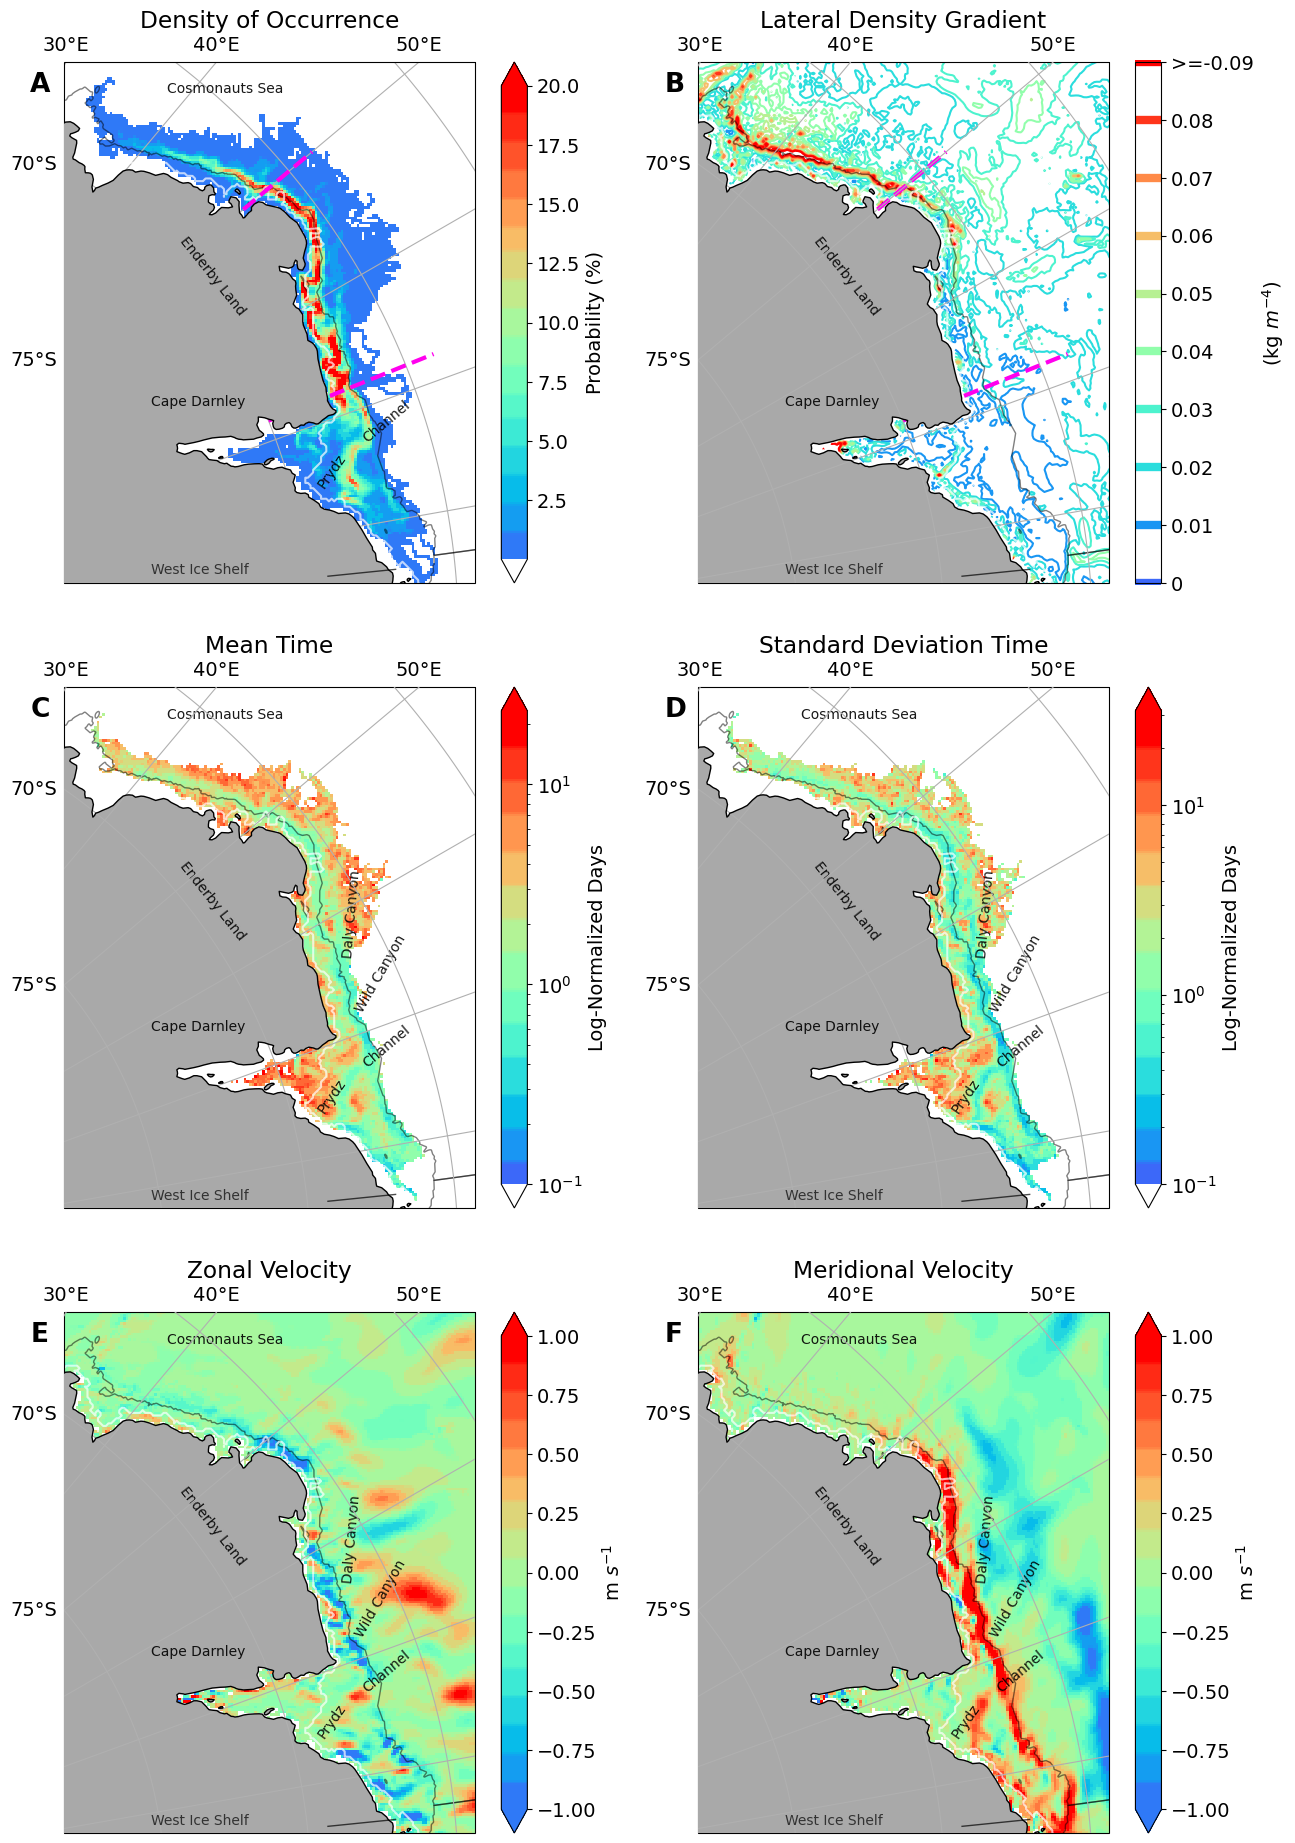

In [52]:
# add another plot of the density field
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(15,23))
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
plt.rcParams.update({'font.size': 14})

############################################################
# density map
# setup
# ax = plt.subplot2grid((4, 2), (0, 0), rowspan=4,projection=proj)
ax = fig.add_subplot(321, projection=proj)
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1290000,2900000])
plt.ylim([210000,2250000])
# cmap = plt.get_cmap('Blues',20).copy()
cmap = plt.get_cmap('rainbow',20).copy()

cmap = truncate_colormap(cmap, 0.15)
cmap.set_under(color='white')

# log scaling
ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='solid', linewidth=1,alpha=0.5)
plt.contour(dg.lon_rho[1:,300:], dg.lat_rho[1:,300:],ds1.zice[1:,300:],levels=[-0.1],
            zorder=2,linestyles='solid', transform=ccrs.PlateCarree(), cmap=plt.cm.binary,alpha=0.7)
plt.pcolormesh(long,lat,mesh,transform=ccrs.PlateCarree(),zorder=1,cmap=cmap,vmin=0.01,vmax=20)

# add the transect lines
lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]

lon_ini = [50,68]
lon_end = [50,68]
lat_ini = [-70,-70]
lat_end = [-64,-64]

ii = 0
plt.plot([lon_ini[ii], lon_end[ii]], [lat_ini[ii], lat_end[ii]],alpha=1,zorder=2, transform=ccrs.PlateCarree(), linewidth=3, linestyle='dashed',color="#ff00ee")
ii = 1
plt.plot([lon_ini[ii], lon_end[ii]], [lat_ini[ii], lat_end[ii]],alpha=1,zorder=2, transform=ccrs.PlateCarree(), linewidth=3, linestyle='dashed',color="#ff00ee")

# latlong ticks
gl = ax.gridlines(zorder=1,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)

# labels
plt.title("Density of Occurrence")
cbar = plt.colorbar(label="Probability (%)",extend='both')
plt.text(x=54, y=-71,s="Enderby Land",transform=ccrs.PlateCarree(),rotation=-51.5,fontsize=10,alpha=0.9)
plt.text(x=61, y=-73.4,s="Cape Darnley",transform=ccrs.PlateCarree(),rotation=0,fontsize=10,alpha=0.9)
plt.text(x=75.65, y=-69.2,s="Prydz",transform=ccrs.PlateCarree(),rotation=-305,fontsize=10,alpha=0.9)
plt.text(x=72.7, y=-67.3,s="Channel",transform=ccrs.PlateCarree(),rotation=-320,fontsize=10,alpha=0.9)
# plt.text(x=63.2, y=-66.5,s="Daly Canyon",transform=ccrs.PlateCarree(),rotation=-275,fontsize=10,alpha=0.9)
# plt.text(x=68, y=-66.9,s="Wild Canyon",transform=ccrs.PlateCarree(),rotation=-300,fontsize=10,alpha=0.9,zorder=3)
plt.text(x=38.5, y=-66,s="Cosmonauts Sea",transform=ccrs.PlateCarree(),rotation=0,fontsize=10,alpha=0.9)
plt.text(x=28.5,y=-68.5,s="A",transform=ccrs.PlateCarree(),fontsize=19,weight="bold")

# test
plt.text(x=81.5, y=-75.3,s="West Ice Shelf",transform=ccrs.PlateCarree(),rotation=0,fontsize=10,alpha=0.7,zorder=5)
plt.plot([84.2, 84.2], [-69.3, -67], 'k-', lw=1,transform=ccrs.PlateCarree(),zorder=10,alpha=0.7)


############################################################
# lateral density gradient
ax = fig.add_subplot(322, projection=proj)
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1290000,2900000])
plt.ylim([210000,2250000])
cmap = mpl.cm.get_cmap("rainbow",16).copy()
cmap = truncate_colormap(cmap, 0.15)
cmap.set_under(color='white')

# log scaling
ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='solid', linewidth=1,alpha=0.5)
plt.contour(dg.lon_rho[1:,300:], dg.lat_rho[1:,300:],ds1.zice[1:,300:],levels=[-0.1],
            zorder=2,linestyles='solid', transform=ccrs.PlateCarree(), cmap=plt.cm.binary,alpha=0.7)

#plt.contour(np.swapaxes(long,0,1),np.swapaxes(lat,0,1),tmp, levels=levels,transform=ccrs.PlateCarree(),linestyles="solid",cmap=cmap,zorder=10)
plt.contour(long[400:,300:],lat[400:,300:],tmp[400:,300:], levels=levels,transform=ccrs.PlateCarree(),linestyles="solid",cmap=cmap,zorder=1)


ii = 0
plt.plot([lon_ini[ii], lon_end[ii]], [lat_ini[ii], lat_end[ii]],alpha=1,zorder=2, transform=ccrs.PlateCarree(), linewidth=3, linestyle='dashed',color="#ff00ee")
ii = 1
plt.plot([lon_ini[ii], lon_end[ii]], [lat_ini[ii], lat_end[ii]],alpha=1,zorder=2, transform=ccrs.PlateCarree(), linewidth=3, linestyle='dashed',color="#ff00ee")

# latlong ticks
gl = ax.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)

# labels
plt.title("Lateral Density Gradient")
cbar = plt.colorbar(label="(kg $m^{-4}$)",extend='both')
cbar.lines[0].set_linewidth(6)
cbar.ax.set_yticklabels(['0', '0.01','0.02','0.03','0.04','0.05','0.06','0.07','0.08', '>=-0.09'])


plt.text(x=54, y=-71,s="Enderby Land",transform=ccrs.PlateCarree(),rotation=-51.5,fontsize=10,alpha=0.9)
plt.text(x=61, y=-73.4,s="Cape Darnley",transform=ccrs.PlateCarree(),rotation=0,fontsize=10,alpha=0.9)
plt.text(x=28.5,y=-68.5,s="B",transform=ccrs.PlateCarree(),fontsize=19,weight="bold")

# test
plt.text(x=81.5, y=-75.3,s="West Ice Shelf",transform=ccrs.PlateCarree(),rotation=0,fontsize=10,alpha=0.7,zorder=5)
plt.plot([84.2, 84.2], [-69.3, -67], 'k-', lw=1,transform=ccrs.PlateCarree(),zorder=10,alpha=0.7)

############################################################
# average values
ax = fig.add_subplot(323, projection=proj) 
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1290000,2900000])
plt.ylim([210000,2250000])
cmap = mpl.cm.get_cmap("rainbow",16).copy()
cmap = truncate_colormap(cmap, 0.15)
cmap.set_under(color='white')

# log scaling
ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='solid', linewidth=1,alpha=0.5)
plt.contour(dg.lon_rho[1:,300:], dg.lat_rho[1:,300:],ds1.zice[1:,300:],levels=[-0.1],
            zorder=2,linestyles='solid', transform=ccrs.PlateCarree(), cmap=plt.cm.binary,alpha=0.7)
plt.pcolormesh(long,lat,avgmesh,
               norm=colors.LogNorm(vmin=10e-2,vmax=avgmesh[420:580,300:530].max()),
               transform=ccrs.PlateCarree(),zorder=1,cmap=cmap)
# plt.pcolormesh(long,lat,avgmesh,transform=ccrs.PlateCarree(),zorder=1,cmap=cmap)

# latlong ticks
gl = ax.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)

# labels
plt.title("Mean Time")
cbar = plt.colorbar(label="Log-Normalized Days",extend='both')
plt.text(x=54, y=-71,s="Enderby Land",transform=ccrs.PlateCarree(),rotation=-51.5,fontsize=10,alpha=0.9)
plt.text(x=61, y=-73.4,s="Cape Darnley",transform=ccrs.PlateCarree(),rotation=0,fontsize=10,alpha=0.9)
plt.text(x=75.65, y=-69.2,s="Prydz",transform=ccrs.PlateCarree(),rotation=-305,fontsize=10,alpha=0.9)
plt.text(x=72.7, y=-67.3,s="Channel",transform=ccrs.PlateCarree(),rotation=-320,fontsize=10,alpha=0.9)
plt.text(x=63.2, y=-66.5,s="Daly Canyon",transform=ccrs.PlateCarree(),rotation=-275,fontsize=10,alpha=0.9)
plt.text(x=68, y=-66.9,s="Wild Canyon",transform=ccrs.PlateCarree(),rotation=-300,fontsize=10,alpha=0.9,zorder=3)
plt.text(x=38.5, y=-66,s="Cosmonauts Sea",transform=ccrs.PlateCarree(),rotation=0,fontsize=10,alpha=0.9)
plt.text(x=28.5,y=-68.5,s="C",transform=ccrs.PlateCarree(),fontsize=19,weight="bold")

# test
plt.text(x=81.5, y=-75.3,s="West Ice Shelf",transform=ccrs.PlateCarree(),rotation=0,fontsize=10,alpha=0.7,zorder=5)
plt.plot([84.2, 84.2], [-69.3, -67], 'k-', lw=1,transform=ccrs.PlateCarree(),zorder=10,alpha=0.7)

############################################################
# stdev values
ax = fig.add_subplot(324, projection=proj) 
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1290000,2900000])
plt.ylim([210000,2250000])

# log scaling
ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='solid', linewidth=1,alpha=0.5)
plt.contour(dg.lon_rho[1:,300:], dg.lat_rho[1:,300:],ds1.zice[1:,300:],levels=[-0.1],
            zorder=2,linestyles='solid', transform=ccrs.PlateCarree(), cmap=plt.cm.binary,alpha=0.7)
plt.pcolormesh(long,lat,mesh_std,
               norm=colors.LogNorm(vmin=10e-2,vmax=mesh_std[420:580,300:530].max()),
               transform=ccrs.PlateCarree(),zorder=1,cmap=cmap)

# latlong ticks
gl = ax.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)

# labels
plt.title("Standard Deviation Time")
cbar = plt.colorbar(label="Log-Normalized Days",extend='both')
plt.text(x=54, y=-71,s="Enderby Land",transform=ccrs.PlateCarree(),rotation=-51.5,fontsize=10,alpha=0.9)
plt.text(x=61, y=-73.4,s="Cape Darnley",transform=ccrs.PlateCarree(),rotation=0,fontsize=10,alpha=0.9)
plt.text(x=75.65, y=-69.2,s="Prydz",transform=ccrs.PlateCarree(),rotation=-305,fontsize=10,alpha=0.9)
plt.text(x=72.7, y=-67.3,s="Channel",transform=ccrs.PlateCarree(),rotation=-320,fontsize=10,alpha=0.9)
plt.text(x=63.2, y=-66.5,s="Daly Canyon",transform=ccrs.PlateCarree(),rotation=-275,fontsize=10,alpha=0.9)
plt.text(x=68, y=-66.9,s="Wild Canyon",transform=ccrs.PlateCarree(),rotation=-300,fontsize=10,alpha=0.9,zorder=3)
plt.text(x=38.5, y=-66,s="Cosmonauts Sea",transform=ccrs.PlateCarree(),rotation=0,fontsize=10,alpha=0.9)
plt.text(x=28.5,y=-68.5,s="D",transform=ccrs.PlateCarree(),fontsize=19,weight="bold")

# test
plt.text(x=81.5, y=-75.3,s="West Ice Shelf",transform=ccrs.PlateCarree(),rotation=0,fontsize=10,alpha=0.7,zorder=5)
plt.plot([84.2, 84.2], [-69.3, -67], 'k-', lw=1,transform=ccrs.PlateCarree(),zorder=10,alpha=0.7)

############################################################

# eulerian speed
ax = fig.add_subplot(325, projection=proj) 
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1290000,2900000])
plt.ylim([210000,2250000])

cmap = plt.get_cmap('rainbow',20).copy()
cmap = truncate_colormap(cmap, 0.15)

# log scaling
ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='solid', linewidth=1,alpha=0.5)
plt.contour(dg.lon_rho[1:,300:], dg.lat_rho[1:,300:],ds1.zice[1:,300:],levels=[-0.1],
            zorder=2,linestyles='solid', transform=ccrs.PlateCarree(), cmap=plt.cm.binary,alpha=0.7)

plt.pcolormesh(long,lat,u_new,vmin=-1,vmax=1,transform=ccrs.PlateCarree(),zorder=1,cmap=cmap)

# latlong ticks
gl = ax.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)

# labels
plt.title("Zonal Velocity")
cbar = plt.colorbar(label="m $s^{-1}$",extend='both')
plt.text(x=54, y=-71,s="Enderby Land",transform=ccrs.PlateCarree(),rotation=-51.5,fontsize=10,alpha=0.9)
plt.text(x=61, y=-73.4,s="Cape Darnley",transform=ccrs.PlateCarree(),rotation=0,fontsize=10,alpha=0.9)
plt.text(x=75.65, y=-69.2,s="Prydz",transform=ccrs.PlateCarree(),rotation=-305,fontsize=10,alpha=0.9)
plt.text(x=72.7, y=-67.3,s="Channel",transform=ccrs.PlateCarree(),rotation=-320,fontsize=10,alpha=0.9)
plt.text(x=63.2, y=-66.5,s="Daly Canyon",transform=ccrs.PlateCarree(),rotation=-275,fontsize=10,alpha=0.9)
plt.text(x=68, y=-66.9,s="Wild Canyon",transform=ccrs.PlateCarree(),rotation=-300,fontsize=10,alpha=0.9,zorder=3)
plt.text(x=38.5, y=-66,s="Cosmonauts Sea",transform=ccrs.PlateCarree(),rotation=0,fontsize=10,alpha=0.9)
plt.text(x=28.5,y=-68.5,s="E",transform=ccrs.PlateCarree(),fontsize=19,weight="bold")

# test
plt.text(x=81.5, y=-75.3,s="West Ice Shelf",transform=ccrs.PlateCarree(),rotation=0,fontsize=10,alpha=0.7,zorder=5)
plt.plot([84.2, 84.2], [-69.3, -67], 'k-', lw=1,transform=ccrs.PlateCarree(),zorder=10,alpha=0.7)

############################################################

# eulerian speed
ax = fig.add_subplot(326, projection=proj) 
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1290000,2900000])
plt.ylim([210000,2250000])

# log scaling
ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='solid', linewidth=1,alpha=0.5)
plt.contour(dg.lon_rho[1:,300:], dg.lat_rho[1:,300:],ds1.zice[1:,300:],levels=[-0.1],
            zorder=2,linestyles='solid', transform=ccrs.PlateCarree(), cmap=plt.cm.binary,alpha=0.7)

plt.pcolormesh(long,lat,v_new,vmin=-1,vmax=1,transform=ccrs.PlateCarree(),zorder=1,cmap=cmap)

# latlong ticks
gl = ax.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)

# labels
plt.title("Meridional Velocity")
cbar = plt.colorbar(label="m $s^{-1}$",extend='both')
plt.text(x=54, y=-71,s="Enderby Land",transform=ccrs.PlateCarree(),rotation=-51.5,fontsize=10,alpha=0.9)
plt.text(x=61, y=-73.4,s="Cape Darnley",transform=ccrs.PlateCarree(),rotation=0,fontsize=10,alpha=0.9)
plt.text(x=75.65, y=-69.2,s="Prydz",transform=ccrs.PlateCarree(),rotation=-305,fontsize=10,alpha=0.9)
plt.text(x=72.7, y=-67.3,s="Channel",transform=ccrs.PlateCarree(),rotation=-320,fontsize=10,alpha=0.9)
plt.text(x=63.2, y=-66.5,s="Daly Canyon",transform=ccrs.PlateCarree(),rotation=-275,fontsize=10,alpha=0.9)
plt.text(x=68, y=-66.9,s="Wild Canyon",transform=ccrs.PlateCarree(),rotation=-300,fontsize=10,alpha=0.9,zorder=3)
plt.text(x=38.5, y=-66,s="Cosmonauts Sea",transform=ccrs.PlateCarree(),rotation=0,fontsize=10,alpha=0.9)
plt.text(x=28.5,y=-68.5,s="F",transform=ccrs.PlateCarree(),fontsize=19,weight="bold")

# test
plt.text(x=81.5, y=-75.3,s="West Ice Shelf",transform=ccrs.PlateCarree(),rotation=0,fontsize=10,alpha=0.7,zorder=5)
plt.plot([84.2, 84.2], [-69.3, -67], 'k-', lw=1,transform=ccrs.PlateCarree(),zorder=10,alpha=0.7)

############################################################

fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig_path='/scratch/project_2000789/muramarg/reviews1/'
plt.savefig(fig_path + 'figure4_withvelocity_withdz_v2.png',dpi=300)